In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter 
from typing import Literal, Union, Optional, List
import utils
from scipy.stats import pearsonr, spearmanr

In [3]:
libra_df = pd.read_csv('data/Libra.csv')
libra_G = nx.from_pandas_edgelist(libra_df,source = 'Source', target = 'Target', edge_attr=True,create_using=nx.DiGraph)
print('The libra |N|:',libra_G.number_of_nodes())


rabo_G = nx.read_edgelist('data/rabo_easylabel.edgelist',data=(("Total",float),("Count", int)), create_using=nx.DiGraph)
print('The rabo |N|:',rabo_G.number_of_nodes())
rabo_df = nx.to_pandas_edgelist(rabo_G,source='Source',target='Target')

The libra |N|: 385100
The rabo |N|: 1624030


In [4]:
def show_basics(G,df):
    N  = G.number_of_nodes()
    print('|N|: ', G.number_of_nodes())
    print('|E|: ', G.number_of_edges())
    print('|W_T|: ', df['Total'].sum())
    print('|W_C|: ', df['Count'].sum())
    print('reciprocity: ', nx.reciprocity(G))
    print('average clustering coef: ',nx.approximation.average_clustering(nx.Graph(G),trials=int(0.01*N),seed=101))


    degrees = [degree for node, degree in G.degree()]
    avg_degree = sum(degrees) / G.number_of_nodes()
    print('average degree: ', avg_degree)

    df.groupby('Source').size().reset_index()
    source = set(df.groupby('Source').size().reset_index()['Source'])
    target = set(df.groupby('Target').size().reset_index()['Target'])
    print('number of nodes who have at least one out_degree:',len(source))
    print('number of nodes who have at least one in_degree:',len(target))
    print('intersection of the above two: ', len(source&target))





In [5]:
show_basics(rabo_G,rabo_df)

|N|:  1624030
|E|:  3823167
|W_T|:  291294725973.0
|W_C|:  110609151
reciprocity:  0.26319697779354134
average clustering coef:  0.020997536945812807
average degree:  4.708246768840477
number of nodes who have at least one out_degree: 1300207
number of nodes who have at least one in_degree: 690490
intersection of the above two:  366667


In [6]:
libra_df.head()

,Source,Target,Total,Count
0,0,349867,1400.0,1
1,0,351343,4000.0,1
2,0,350363,30560.0,4
3,0,349658,5200.0,2
4,1,351895,646.0,1


In [7]:
out_transfer = libra_df.groupby('Source')[['Total','Count']].sum().reset_index(names='user_id')
out_transfer.columns = ['user_id','out_total','out_count']
in_transfer = libra_df.groupby('Target')[['Total','Count']].sum().reset_index(names='user_id')
in_transfer.columns = ['user_id','in_total','in_count']

In [8]:
df_out_degree = libra_df.groupby('Source').size().reset_index()
df_out_degree.columns = ['user_id','out_degree']
df_in_degree = libra_df.groupby('Target').size().reset_index()
df_in_degree.columns = ['user_id','in_degree']

In [9]:
merged_df = pd.merge(out_transfer, in_transfer, on='user_id', how='outer')
merged_df = pd.merge(merged_df, df_out_degree, on='user_id', how='outer')
merged_df = pd.merge(merged_df, df_in_degree, on='user_id', how='outer')
merged_df = merged_df.fillna(0)

In [10]:
merged_df

,user_id,out_total,out_count,in_total,in_count,out_degree,in_degree
0,0,41160.00,8.0,0.00,0.0,4.0,0.0
1,1,646.00,1.0,0.00,0.0,1.0,0.0
2,2,60.49,2.0,0.00,0.0,1.0,0.0
3,3,1884.00,2.0,0.00,0.0,1.0,0.0
4,4,111.00,1.0,0.00,0.0,1.0,0.0
...,...,...,...,...,...,...,...
385095,385094,0.00,0.0,104189.81,3.0,0.0,1.0
385096,385095,0.00,0.0,18000.00,1.0,0.0,1.0
385097,385096,0.00,0.0,200.00,1.0,0.0,1.0
385098,385098,0.00,0.0,50.00,1.0,0.0,1.0


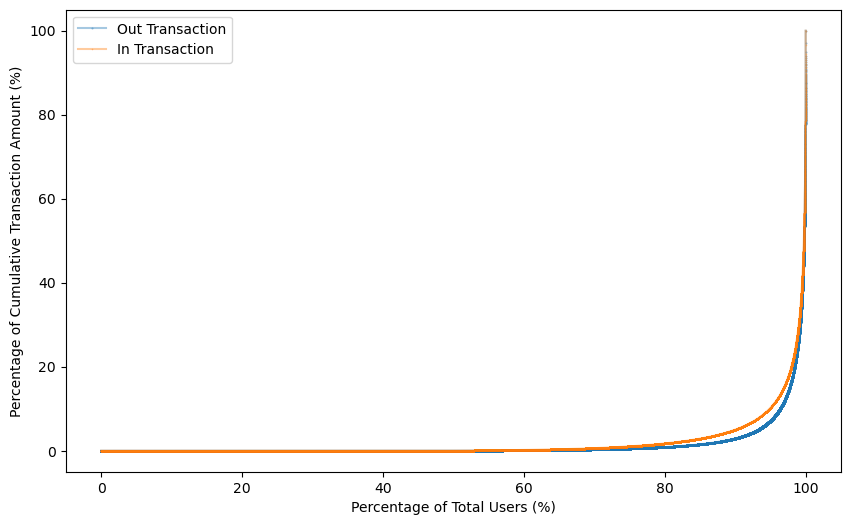

In [11]:

sorted_out_df = merged_df.sort_values(by ='out_total').reset_index(drop=True)
sorted_out_df['cumulative_out_total'] = sorted_out_df['out_total'].cumsum()
sorted_out_df['user_percentage'] = (sorted_out_df.index + 1) / len(sorted_out_df) * 100
sorted_out_df['cumulative_out_total_percentage'] = sorted_out_df['cumulative_out_total'] / sorted_out_df['out_total'].sum() * 100


sorted_in_df = merged_df.sort_values(by='in_total').reset_index(drop=True)
sorted_in_df['cumulative_in_total'] = sorted_in_df['in_total'].cumsum()
sorted_in_df['user_percentage'] = (sorted_in_df.index + 1) / len(sorted_in_df) * 100
sorted_in_df['cumulative_in_total_percentage'] = sorted_in_df['cumulative_in_total'] / sorted_in_df['in_total'].sum() * 100


plt.figure(figsize=(10, 6))
plt.plot(sorted_out_df['user_percentage'], sorted_out_df['cumulative_out_total_percentage'], marker='o', label='Out Transaction',markersize=0.5,alpha=0.4)


plt.plot(sorted_in_df['user_percentage'], sorted_in_df['cumulative_in_total_percentage'], marker='x', label='In Transaction',markersize=0.5,alpha=0.4)


plt.xlabel('Percentage of Total Users (%)')
plt.ylabel('Percentage of Cumulative Transaction Amount (%)')
plt.legend()
plt.show()

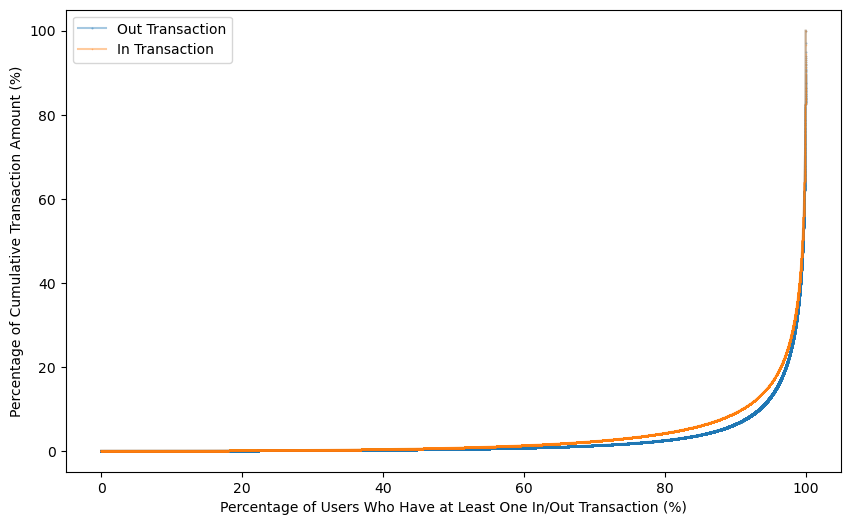

In [12]:
filter_df = merged_df[merged_df['out_degree'] > 0]
sorted_out_df = filter_df.sort_values(by ='out_total').reset_index(drop=True)
sorted_out_df['cumulative_out_total'] = sorted_out_df['out_total'].cumsum()
sorted_out_df['user_percentage'] = (sorted_out_df.index + 1) / len(sorted_out_df) * 100
sorted_out_df['cumulative_out_total_percentage'] = sorted_out_df['cumulative_out_total'] / sorted_out_df['out_total'].sum() * 100

filter_df = merged_df[merged_df['in_degree'] > 0]
sorted_in_df = filter_df.sort_values(by='in_total').reset_index(drop=True)
sorted_in_df['cumulative_in_total'] = sorted_in_df['in_total'].cumsum()
sorted_in_df['user_percentage'] = (sorted_in_df.index + 1) / len(sorted_in_df) * 100
sorted_in_df['cumulative_in_total_percentage'] = sorted_in_df['cumulative_in_total'] / sorted_in_df['in_total'].sum() * 100


plt.figure(figsize=(10, 6))
plt.plot(sorted_out_df['user_percentage'], sorted_out_df['cumulative_out_total_percentage'], marker='o', label='Out Transaction',markersize=0.5,alpha=0.4)


plt.plot(sorted_in_df['user_percentage'], sorted_in_df['cumulative_in_total_percentage'], marker='x', label='In Transaction',markersize=0.5,alpha=0.4)


plt.xlabel('Percentage of Users Who Have at Least One In/Out Transaction (%)')
plt.ylabel('Percentage of Cumulative Transaction Amount (%)')
plt.legend()
plt.show()

### discover some relationships

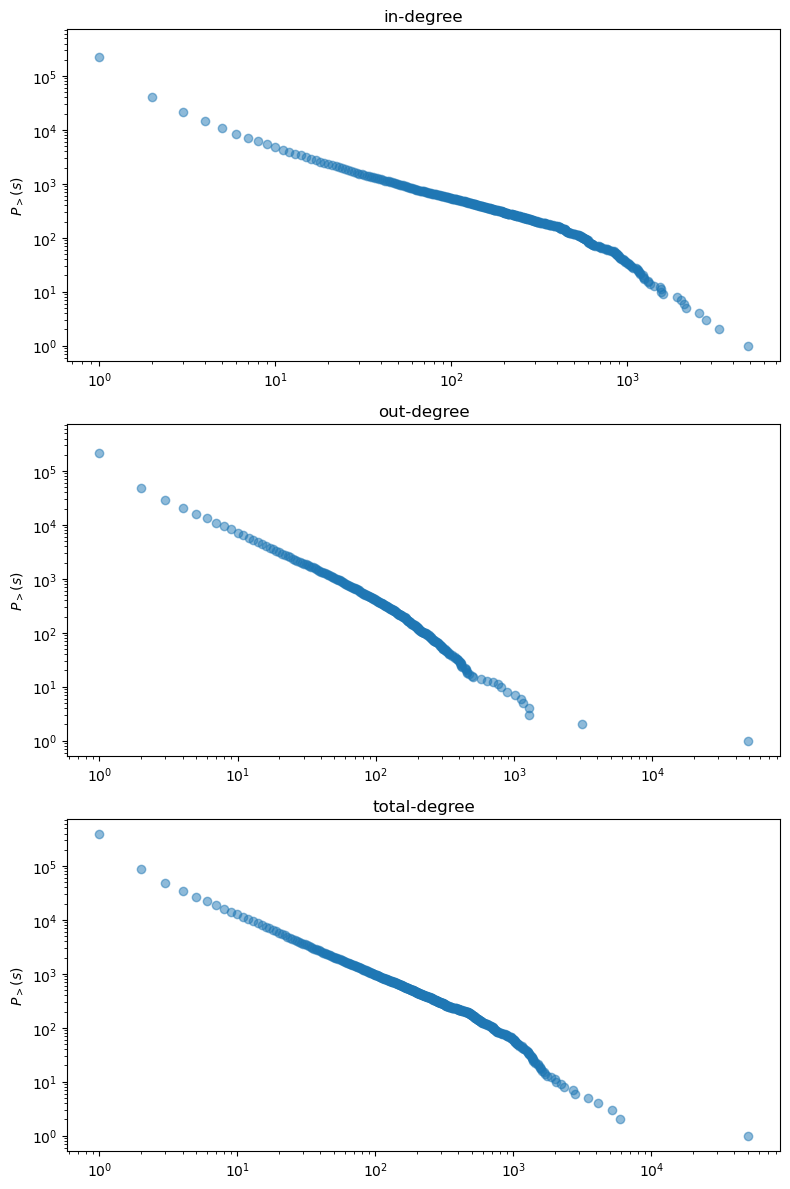

In [13]:
utils.degree_scatter(libra_G,type_list=['in','out','total'],log=True, alpha=0.5)

Calculating best minimal value for power law fit
d:\Anaconda\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


Power law coefficient (alpha): 2.155102967544903


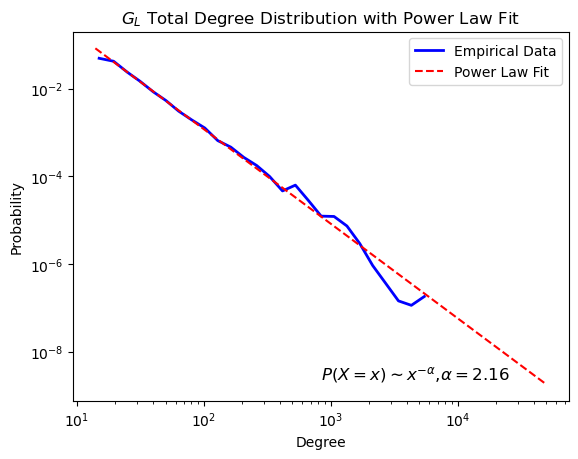

In [14]:
import powerlaw
total_degrees = [d for n, d in libra_G.degree()]

# Fit the degree distribution to a power law
fit = powerlaw.Fit(total_degrees,cumulative=True)

# Extract the power law coefficient (alpha)
alpha = fit.power_law.alpha
print(f"Power law coefficient (alpha): {alpha}")

# Plot the degree distribution and the fitted power law
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)

text_str = f'$P(X = x) \sim x^{{-\\alpha}}$,$\\alpha = {alpha:.2f}$'
plt.text(0.5, 0.1, text_str, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title(r'$G_{L}$ Total Degree Distribution with Power Law Fit')
plt.legend(['Empirical Data', 'Power Law Fit'])
plt.show()


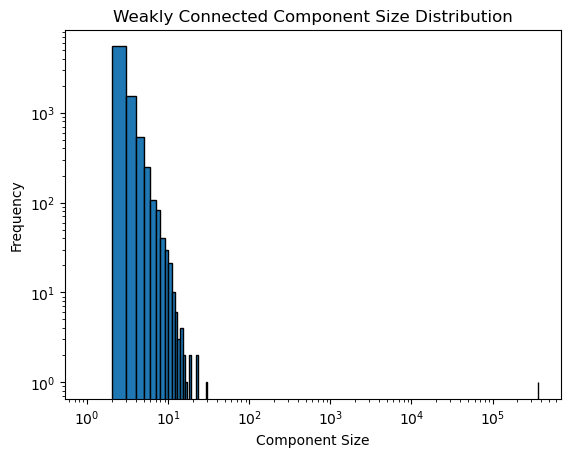

In [15]:
wcc_sizes = [len(c) for c in nx.weakly_connected_components(libra_G)]

# Plot the size distribution of weakly connected components
plt.hist(wcc_sizes, bins=range(1, max(wcc_sizes) + 1), edgecolor='black')
plt.xlabel('Component Size')
plt.ylabel('Frequency')
plt.title('Weakly Connected Component Size Distribution')
plt.yscale('log')  # Use a log scale if component sizes span several orders of magnitude
plt.xscale('log')  
plt.show()

### degree correlation and so on


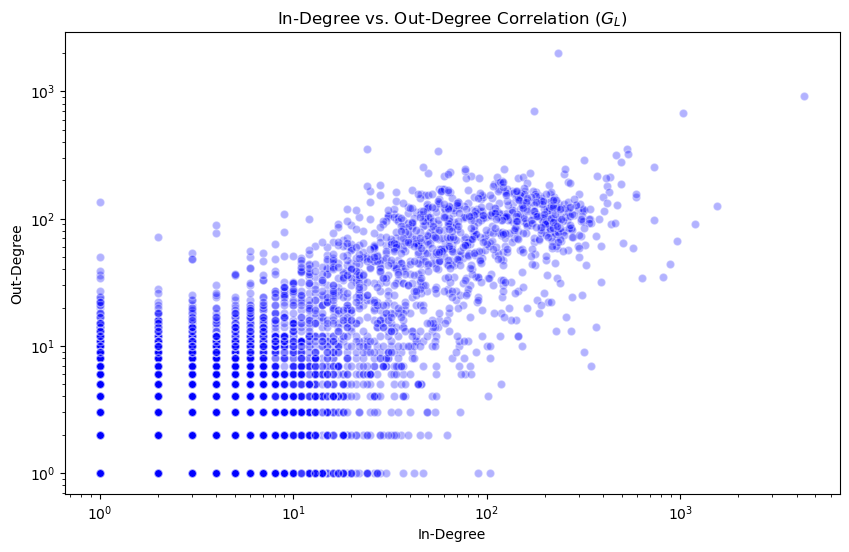

In [63]:
# Calculate in-degrees and out-degrees
in_degrees = dict(rabo_G.in_degree())
out_degrees = dict(rabo_G.out_degree())

# Extract values for scatter plot
in_deg_values = np.array(list(in_degrees.values()))
out_deg_values = np.array(list(out_degrees.values()))

sample_size = int(0.05 * len(in_deg_values))

# Sample indices
sample_indices = np.random.choice(len(in_deg_values), sample_size, replace=False)

# Sampled in-degrees and out-degrees
sampled_in_degrees = in_deg_values[sample_indices]
sampled_out_degrees = out_deg_values[sample_indices]

# Create a scatter plot of in-degree vs. out-degree
plt.figure(figsize=(10, 6))
plt.scatter(sampled_in_degrees, sampled_out_degrees, alpha=0.3, c='b',edgecolors='w')

# Apply log scale to both axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In-Degree')
plt.ylabel('Out-Degree')
plt.title(r'In-Degree vs. Out-Degree Correlation $(G_{L})$')

plt.show()

In [65]:
pearson_corr, a = pearsonr(in_deg_values, out_deg_values)
print(pearson_corr,a)
spearman_corr, sig = spearmanr(in_deg_values, out_deg_values)
print(spearman_corr,sig)

0.5867378749465194 0.0
-0.14794072373611167 0.0


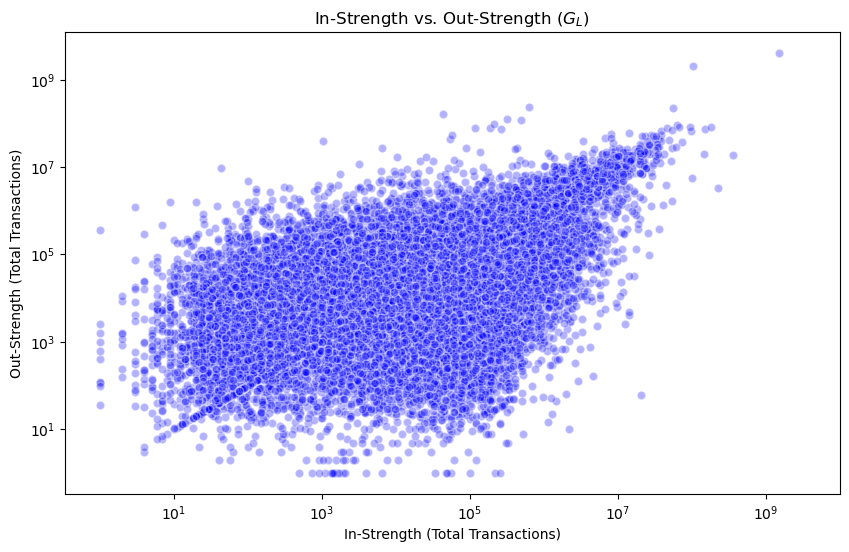

In [66]:
in_strengths = {node: 0 for node in rabo_G.nodes()}
out_strengths = {node: 0 for node in rabo_G.nodes()}

for u, v, data in rabo_G.edges(data=True):
    weight = data.get('Total', 1)  # Default weight is 1 if 'Total' attribute is missing
    in_strengths[v] += weight
    out_strengths[u] += weight

# Extract values for scatter plot
in_strength_values = np.array(list(in_strengths.values()))
out_strength_values = np.array(list(out_strengths.values()))


sample_size = int(0.05 * len(in_strength_values))

# Sample indices
sample_indices = np.random.choice(len(in_strength_values), sample_size, replace=False)

# Sampled in-degrees and out-degrees
sampled_in_strengths = in_strength_values[sample_indices]
sampled_out_strengths = out_strength_values[sample_indices]
# Create a scatter plot of in-strength vs. out-strength
plt.figure(figsize=(10, 6))
plt.scatter(sampled_in_strengths, sampled_out_strengths, alpha=0.3, c='blue',edgecolors='w')

# Apply log scale to both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('In-Strength (Total Transactions)')
plt.ylabel('Out-Strength (Total Transactions)')
plt.title(r'In-Strength vs. Out-Strength $(G_{L})$')


# Display the plot
plt.show()

In [67]:
pearson_corr, a = pearsonr(in_strength_values, out_strength_values)
print(pearson_corr)
spearman_corr, _ = spearmanr(in_strength_values, out_strength_values)
print(spearman_corr)

0.3317783632614501
-0.0762632810264501


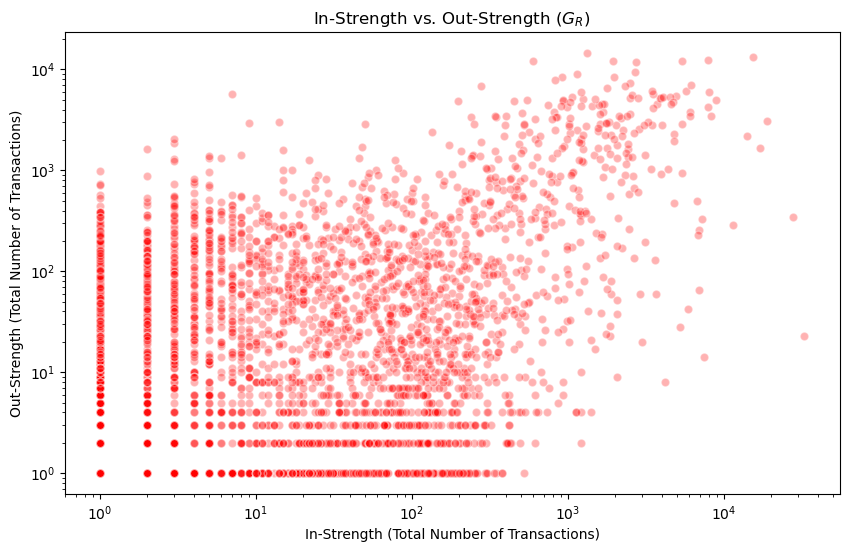

In [68]:
in_strengths = {node: 0 for node in rabo_G.nodes()}
out_strengths = {node: 0 for node in rabo_G.nodes()}

for u, v, data in rabo_G.edges(data=True):
    weight = data.get('Count', 1)  # Default weight is 1 if 'Total' attribute is missing
    in_strengths[v] += weight
    out_strengths[u] += weight
    
# Extract values for scatter plot
in_strength_values = np.array(list(in_strengths.values()))
out_strength_values = np.array(list(out_strengths.values()))


sample_size = int(0.01 * len(in_strength_values))

# Sample indices
sample_indices = np.random.choice(len(in_strength_values), sample_size, replace=False)

# Sampled in-degrees and out-degrees
sampled_in_strengths = in_strength_values[sample_indices]
sampled_out_strengths = out_strength_values[sample_indices]
# Create a scatter plot of in-strength vs. out-strength
plt.figure(figsize=(10, 6))
plt.scatter(sampled_in_strengths, sampled_out_strengths, alpha=0.3, c='r',edgecolors='w')

# Add labels and title
plt.xlabel('In-Strength (Total Number of Transactions)')
plt.ylabel('Out-Strength (Total Number of Transactions)')
plt.title(r'In-Strength vs. Out-Strength $(G_{R})$')

plt.xscale('log')
plt.yscale('log')
# Display the plot
plt.show()

In [69]:
pearson_corr, a = pearsonr(in_strength_values, out_strength_values)
print(pearson_corr)
spearman_corr, _ = spearmanr(in_strength_values, out_strength_values)
print(spearman_corr)

0.15887847029454555
-0.09249793327810085


### focus on the nodes that have both in-degree and out-degree

In [156]:
# Calculate in-degrees and out-degrees
in_degrees = dict(libra_G.in_degree())
out_degrees = dict(libra_G.out_degree())

# Extract values for scatter plot
in_deg_values = np.array(list(in_degrees.values()))
out_deg_values = np.array(list(out_degrees.values()))

# Filter nodes with at least one in-degree and one out-degree
valid_indices = np.where((in_deg_values > 0) & (out_deg_values > 0))[0]

pearson_coef, pearson_p_value = pearsonr(in_deg_values[valid_indices], out_deg_values[valid_indices])
spearman_coef, spearman_p_value = spearmanr(in_deg_values[valid_indices], out_deg_values[valid_indices])
print(pearson_coef,pearson_p_value)
print(spearman_coef,spearman_p_value)

0.1578833301950824 1.0233805243140431e-275
0.5182172375332802 0.0


In [153]:
# Calculate in-degrees and out-degrees
in_degrees = dict(rabo_G.in_degree())
out_degrees = dict(rabo_G.out_degree())

in_deg_values = np.array(list(in_degrees.values()))
out_deg_values = np.array(list(out_degrees.values()))

valid_indices = np.where((in_deg_values > 0) & (out_deg_values > 0))[0] # node ID
ids = np.array(list(in_degrees.keys()))
valid_node_ids = ids[valid_indices]

# Calculate in-strengths and out-strengths for the valid nodes
in_strengths = {node: 0 for node in rabo_G.nodes()}
out_strengths = {node: 0 for node in rabo_G.nodes()}

for u, v, data in rabo_G.edges(data=True):
    weight = data.get('Count', 0)  # Default weight is 0 if 'Total' attribute is missing
    in_strengths[v] += weight
    out_strengths[u] += weight

In [154]:

in_strength_values = np.array([in_strengths[node] for node in valid_node_ids])
out_strength_values = np.array([out_strengths[node] for node in valid_node_ids])

In [155]:
pearson_coef, pearson_p_value = pearsonr(in_strength_values, out_strength_values)
spearman_coef, spearman_p_value = spearmanr(in_strength_values, out_strength_values)
print(pearson_coef,pearson_p_value)
print(spearman_coef,spearman_p_value)

0.15815004911131925 0.0
0.25479047039386377 0.0
